## Train the PF-Controller Neural Network

For each performance metric, train the corresponding particle-filter (PF) controller neural network.

In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
from src.models.particle_filter.core import ParticleFilterMLP, ParticleFilterModel
from src.helpers.seed import set_global_seed

from experiment_config import (
    DegModel,DATA_NAME,FILTERED_SUFFIX,SEED,PFNET_NAME,LEAKY_SLOPE,HIDDEN_DIMS,PREDICTION_START_IDX
)

## Task

In [2]:
perform_name = 'T48'

## Hyper-Parameters

In [3]:
n_particles = 1600

# Training parameters#
# optimization
lr = 5e-4
weight_decay = 1e-4
gradient_clip = 5.0
 


# Early stopping
n_epochs = 5000
patience = 100          # how many eval steps to wait
min_delta = 1e-4       # minimum improvement to count
beta = 0.9

In [4]:
degmodel_name = DegModel.name()
activation = nn.LeakyReLU(LEAKY_SLOPE)

set_global_seed(SEED)
experiment_dir = Path('experiments')/DATA_NAME
degmodel_dir = experiment_dir/f'degradation{FILTERED_SUFFIX}'/degmodel_name
pfnet_dir = degmodel_dir /'pf_performs'/PFNET_NAME
checkpoint_path = pfnet_dir / perform_name / "checkpoint.pt"
checkpoint_path.parent.mkdir(parents=True, exist_ok=True)

## Import training data

In [5]:
hi_df = pd.read_csv(experiment_dir/f"hidata_dev{FILTERED_SUFFIX}.csv")
units = hi_df['unit'].astype(int).unique().tolist()
units 

[1, 2, 3, 4, 5, 6, 7, 8, 9]

### Extract degradation onset

In [6]:
onsets = {unit: hi_df[(hi_df['unit']==unit) & (hi_df['hs']==0)]['cycle'].values[0] for unit in units}
del hi_df['hs']

In [7]:
perform_names = [col for col in hi_df.columns if col not in ['unit','cycle']]

performs = {name: 
    {unit: hi_df[hi_df['unit']==unit][name].values for unit in units} 
    for name in perform_names
}
time = {unit: hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Create component (base) models

In [8]:
eval_data = {}
eval_eol = {}
for unit in units:
    t_data = time[unit]
    s_data = performs[perform_name][unit]
    eval_data[unit]=torch.tensor(np.stack([t_data, s_data],axis=1),dtype=torch.float32)
    eval_eol[unit]=torch.tensor(t_data[-1],dtype=torch.float32) 


In [9]:
train_degmodels = {}
for eval_unit in units:
    degmodels=[]
    for unit, perform in performs[perform_name].items():
        if unit == eval_unit:
            continue
        best_model = DegModel(onset=onsets[unit])
        best_model.load_state_dict(
            torch.load(degmodel_dir/'states'/perform_name/f'unit_{unit}'/ "best_model.pt")
        )
        degmodels.append(best_model)
    train_degmodels[eval_unit] = degmodels

## Train Particle Filter Net()

In [10]:
net = ParticleFilterMLP(state_dim=DegModel.state_dim(), hidden_dims=HIDDEN_DIMS,
                        activation=lambda : activation)

optimizer = torch.optim.Adam(net.parameters(), lr, weight_decay=weight_decay)
optimizer.zero_grad()

In [11]:
wait = 0             
early_stop = False
ema_loss = None


start_epoch = 0
best_loss = float("inf")
total_loss = 0.0
losses = []
epochs = []
if checkpoint_path.exists():
    ckpt = torch.load(checkpoint_path, weights_only=False)

    net.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])

    start_epoch = ckpt["epoch"] + 1
    best_loss = ckpt["best_loss"]
    losses = ckpt["losses"]
    epochs = ckpt["epochs"]

    ema_loss = ckpt.get("ema_loss", None)

    torch.random.set_rng_state(ckpt["rng_torch"])
    np.random.set_state(ckpt["rng_numpy"])

    print(f"✓ Resumed from epoch {start_epoch}, best_loss={best_loss:.3f}")

In [12]:
for epoch in range(start_epoch, n_epochs):

    epoch_losses = []

    for eval_unit in np.random.permutation(units):
        optimizer.zero_grad()
        degmodels = train_degmodels[eval_unit]
        t_data = eval_data[eval_unit][:, 0]
        s_data = eval_data[eval_unit][:, 1]

        pf = ParticleFilterModel(
            base_models=degmodels,
            net=net,
            n_particles=n_particles,
        ).train()

        unit_loss = 0.0
        n_loss = 0

        for k in range(PREDICTION_START_IDX, len(t_data)):

            mixture_dist = pf.step(
                t_obs=t_data[:k+1],
                s_obs=s_data[:k+1],
            )

            last_dist = mixture_dist.distribution(s=s_data[-1:])
            nll = -last_dist.log_prob(t_data[-1:]).mean()

            unit_loss += nll
            n_loss += 1

        unit_loss = unit_loss / n_loss

        unit_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), gradient_clip)
        optimizer.step()

        epoch_losses.append(unit_loss.item())

    # ---- raw loss ----
    current_loss = float(sum(epoch_losses) / len(epoch_losses))

    # ---- EMA smoothing ----
    if ema_loss is None:
        ema_loss = current_loss
    else:
        ema_loss = beta * ema_loss + (1 - beta) * current_loss

    print(f"[Epoch {epoch:04d}] loss = {current_loss:.3f} | ema = {ema_loss:.3f}")

    losses.append(current_loss)
    epochs.append(epoch)

    # ---- early stopping on EMA ----
    if ema_loss < best_loss - min_delta:
        best_loss = ema_loss
        wait = 0

        checkpoint = {
            'epoch': epoch,
            'model_state': net.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'best_loss': best_loss,
            'losses': losses,
            'epochs': epochs,
            'ema_loss': ema_loss,
            "rng_torch": torch.random.get_rng_state(),
            "rng_numpy": np.random.get_state(),
        }

        torch.save(checkpoint, checkpoint_path)
        print("  + saved (best EMA)")

    else:
        wait += 1
        if wait >= patience:
            print("🛑 Early stopping triggered")
            break

[Epoch 0000] loss = 4.401 | ema = 4.401
  + saved (best EMA)
[Epoch 0001] loss = 4.230 | ema = 4.383
  + saved (best EMA)
[Epoch 0002] loss = 4.248 | ema = 4.370
  + saved (best EMA)
[Epoch 0003] loss = 4.700 | ema = 4.403
[Epoch 0004] loss = 4.559 | ema = 4.419
[Epoch 0005] loss = 4.281 | ema = 4.405
[Epoch 0006] loss = 4.268 | ema = 4.391
[Epoch 0007] loss = 4.442 | ema = 4.396
[Epoch 0008] loss = 4.223 | ema = 4.379
[Epoch 0009] loss = 3.997 | ema = 4.341
  + saved (best EMA)
[Epoch 0010] loss = 4.115 | ema = 4.318
  + saved (best EMA)
[Epoch 0011] loss = 3.673 | ema = 4.254
  + saved (best EMA)
[Epoch 0012] loss = 3.743 | ema = 4.202
  + saved (best EMA)
[Epoch 0013] loss = 4.025 | ema = 4.185
  + saved (best EMA)
[Epoch 0014] loss = 3.973 | ema = 4.164
  + saved (best EMA)
[Epoch 0015] loss = 3.934 | ema = 4.141
  + saved (best EMA)
[Epoch 0016] loss = 3.866 | ema = 4.113
  + saved (best EMA)
[Epoch 0017] loss = 3.881 | ema = 4.090
  + saved (best EMA)
[Epoch 0018] loss = 3.761 | 

# Save last results

In [13]:
if checkpoint_path.exists():
    ckpt:dict = torch.load(checkpoint_path, weights_only=False)
    ckpt.update({
        'epoch': epoch,
        'model_state':net.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'losses': losses,
        'epochs': epochs,
        "rng_torch": torch.random.get_rng_state(),
    	"rng_numpy": np.random.get_state(),
    })
    torch.save(ckpt,checkpoint_path)

    print(f"✓ Resumed from epoch {start_epoch}, best_loss={best_loss:.3f}")

✓ Resumed from epoch 0, best_loss=3.106


## Plot

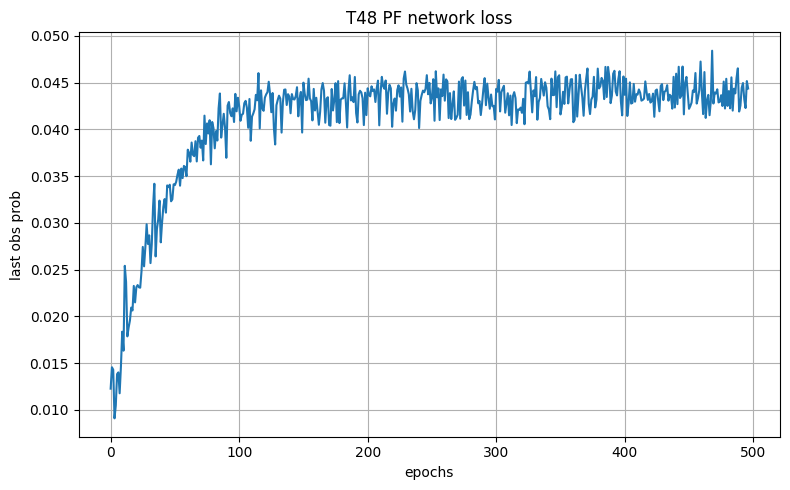

In [14]:
likelihood = np.exp(-np.array(losses))

plt.figure(figsize=(8, 5))
plt.plot(epochs, likelihood)
plt.xlabel('epochs')
plt.ylabel('last obs prob')
plt.title(f'{perform_name} PF network loss')
plt.grid(True)

plt.tight_layout()
plt.savefig(pfnet_dir /perform_name/"net_training_loss.png", dpi=300) 
np.save(pfnet_dir /perform_name/"net_training_loss.npy", np.array(losses))
plt.show()